# Optimization Test

The goal of this notebook is optimizate de potential energy in function of the displacement.

In [2]:
## Import libraires
import jax
import optax
from jax.scipy.special import logsumexp
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pyvista as pv
import Elements as EL
import Material as mat
from Functions import *
from jax import random
import numpy as np
from jax import config
config.update("jax_enable_x64", True)
key = random.key(0)


2024-05-14 21:42:09.940321: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## First Test: Minimize the potential energy, only internal energy consideration

### Unit Block test

In [3]:
#Mesh SET

mesh_file = '/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Meshes/cubo.msh'
mesh = pv.read(mesh_file)  #Orgiinal File
mesh.clear_data()

points_total,connectivity_total,bc_drichlet_cells,bc_neumann_cells = Hex_Reader(mesh_file,
                                                                                drichlet_bc= ["X_1"],plot = False)


#Dritchlet condition 
bc_drichlet_cells['X_1'] = [bc_drichlet_cells['X_1'], jnp.array([1,0,0]) ]

constant = [0.03,3.77]
material = mat.Delphino(constant,100)
malla = EL.Hexs(material, points_total,connectivity_total)

In [3]:
### ANN Model 

# A helper function to randomly initialize weights and biases
# for a dense neural network layer

def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"

def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

@jit
def relu(x):
  return jnp.maximum(0, x)

@jit
def predict(params, disp):
  activations = disp
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

@jit
def vectorized_predict(params,disp):
  result = jax.vmap(predict, in_axes=[None,0])(params,disp)
  result = result.at[:4, :].set(0)
  return result

@jit
def loss_function(params,disp_in):
    constant = material.constants
    disp_out = vectorized_predict(params,disp_in)
    energy_internal = malla.PSI(disp_out,constant)
    return jnp.abs(energy_internal)-0.26

@jit
def Jacobian(params,disp):
    J = jax.grad(loss_function)(params, disp)
    return J

@jit
def update(params, disp):
  grads = Jacobian(params,disp)
  updates, opt_state_1 = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params

# @jit
# def update(params, disp):
#   grads = jax.grad(loss_function)(params, disp)
#   return [(w - step_size * dw, b - step_size * db)
#           for (w, b), (dw, db) in zip(params, grads)]



layer_sizes = [3, 10, 10, 3]
key, subkey = random.split(key)
params = init_network_params(layer_sizes, key)

start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

opt_state = optimizer.init(params)
# params

In [ ]:
import time
num_epochs = 1000

disp_0  = random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1.0)#jnp.zeros_like(points_total) 

loss_curve = []
for epoch in range(num_epochs):
  start_time = time.time()
  params = update(params,disp_0)
  epoch_time = time.time() - start_time
  loss_value = loss_function(params, disp_0)
  loss_curve.append(loss_value) 
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Energy {}".format(loss_value))

print(loss_curve[-1])


In [10]:
points_total
# bc_drichlet_cells

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 1.],
       [0., 1., 0.],
       [1., 1., 0.],
       [1., 1., 1.],
       [0., 1., 1.]])

In [14]:
### Optimization 
#result = result.at[:4, :].set(0)
### Loss function
@jit
def loss_function(disp):
    
    constant = material.constants
    energy_internal = malla.PSI(disp,constant)
    return energy_internal #- energia_externa

@jit
def loss_2(disp):
    disp = u(disp)
    energia_externa = malla.External_Energy(disp, Dritchlet_BC = bc_drichlet_cells)
    energy_internal = loss_function(disp)
    return -1*energy_internal + energia_externa

@jit
def u(disp):
    disp = disp.at[[3, 6, 5], 0].set(1)
    disp = disp.at[0,:].set(0)
    disp = disp.at[1,0].set(1)
    disp = disp.at[1,[1,2]].set(0)
    disp = disp.at[[2,4,7],0].set(0)
    return disp


# @jit
def Jacobian(disp):
    J = jax.jacrev(loss_2)(disp)
    #J = jax.grad(loss_2)(disp)
    
    return J



key, subkey = random.split(key)
disp_0  = jnp.zeros_like(points_total)#+random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1e-1) ##Zero initializaiton
# disp_0  = random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1.0)



In [15]:
## Optax Optimizer ADAM

start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

disp_Adam = disp_0

opt_state = optimizer.init(disp_Adam)
Energys_Adam  = []
for _ in range(10):
  grads = Jacobian(disp_Adam)
  updates, opt_state = optimizer.update(grads, opt_state)
  disp_Adam = optax.apply_updates(disp_Adam, updates)

  Energys_Adam.append(loss_2(disp_Adam))

  # print(_)
  
print('Energy Result',loss_2(disp_Adam)) 
print(u(disp_Adam))

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int64[].
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.
The error occurred while tracing the function loss_2 at /tmp/ipykernel_11897/1877114441.py:11 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    from line /home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Elements.py:90 (_get_nodes)

  operation a:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    from line /home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Material.py:68 (psi)

  operation a:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    from line /home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Elements.py:90 (_get_nodes)

  operation a:i64[] = convert_element_type[new_dtype=int64 weak_type=False] b
    from line /home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Functions.py:83 (Result_Tensor)

  operation a:i64[] = convert_element_type[new_dtype=int64 weak_type=False] b
    from line /home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Functions.py:83 (Result_Tensor)

(Additional originating lines are not shown.)

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [10]:
disp_file  ='/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Displacement_Tests/Cubo_Traccion_X.npy'
disp_FEM = np.load(disp_file)[-1,:,:]  # The order of this file is [time, node, dim]
print(disp_FEM)
print('Energia FEM ', loss_2(jnp.array(disp_FEM)))

[[ 0.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 0.          0.         -0.28788623]
 [ 1.          0.         -0.28788623]
 [ 0.         -0.28788623  0.        ]
 [ 1.         -0.28788623  0.        ]
 [ 1.         -0.28788623 -0.28788623]
 [ 0.         -0.28788623 -0.28788623]]
Energia FEM  -1.78561892960898


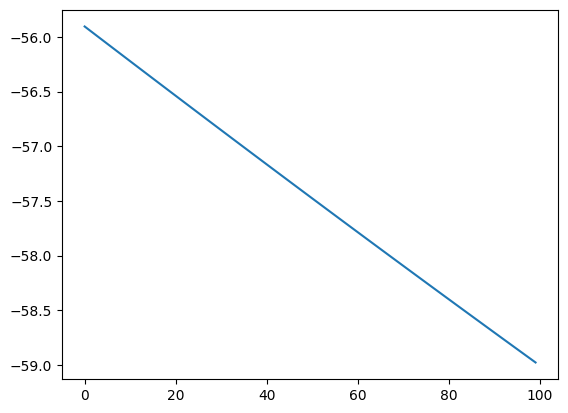

In [35]:
plt.plot(Energys_Adam)

/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


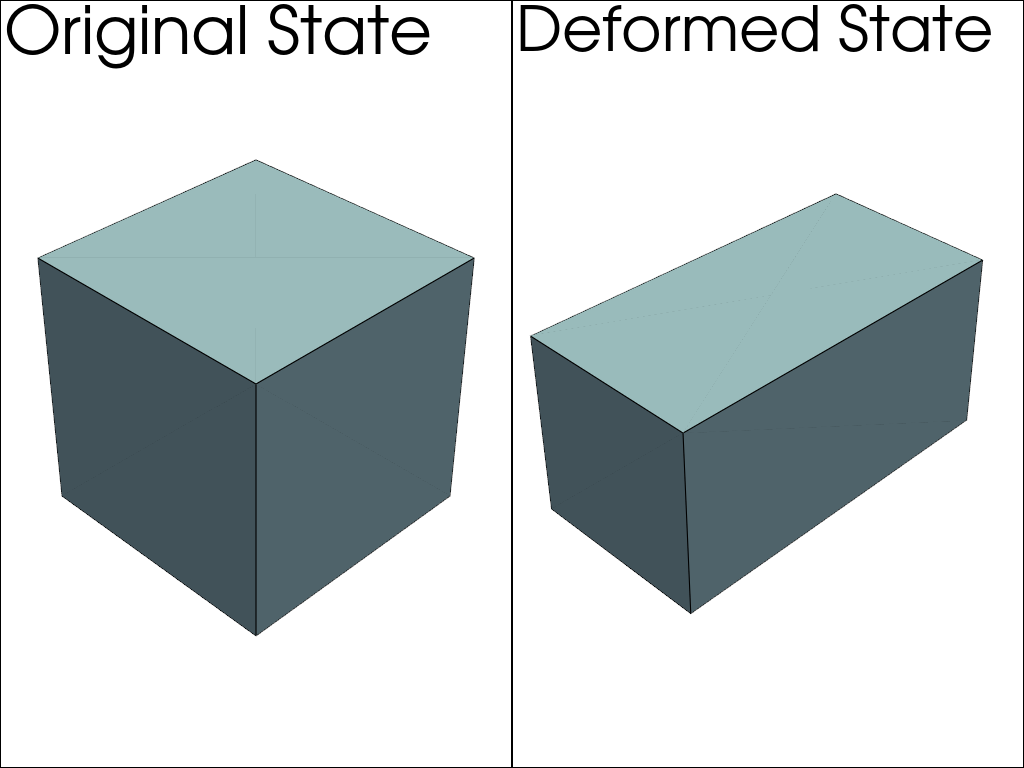

In [36]:
change_state_plot(mesh,u(disp_Adam))

In [38]:
jnp.linalg.det(malla.f(points_total+ u(disp_Adam)))

Array([[2.05953595, 2.03910402, 1.96021197, 1.94065152, 2.07996789,
        2.05953595, 1.94065152, 1.92109108]], dtype=float64)